<a href="https://colab.research.google.com/github/skywalker0803r/AlphaCoin/blob/main/%E5%BE%9E%E9%9B%B6%E9%96%8B%E5%A7%8B%E7%8D%A8%E8%87%AA%E7%A0%94%E7%99%BC%E7%82%92%E5%B9%A3%E7%A8%8B%E5%BC%8F%E7%AC%AC%E5%9B%9B%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 定義隨機森林模型

In [232]:
from abc import ABC
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from typing import Optional
import joblib  # 新增 joblib 支援模型儲存與載入
import os

class BaseStrategy(ABC):
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.signals: Optional[pd.Series] = None

    def get_signals(self) -> pd.Series:
        return self.signals

    def generate_signals(self):
        raise NotImplementedError("Subclasses must implement generate_signals()")


class RandomForestStrategy(BaseStrategy):
    def __init__(self, data: pd.DataFrame, feature_cols: list[str]):
        """
        :param data: 不含標籤的資料，用於產生 signal
        :param feature_cols: 用作訓練與預測的特徵欄位
        """
        super().__init__(data)
        self.feature_cols = feature_cols
        self.model: Optional[RandomForestClassifier] = None

    def fit(self, train_data: pd.DataFrame, label_col: str):
        """
        用訓練資料訓練模型
        :param train_data: 含特徵與標籤的資料（可能與 self.data 不同）
        :param label_col: 標籤欄位名稱，例如 'target'
        """
        X = train_data[self.feature_cols]
        y = train_data[label_col]

        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.model.fit(X, y)
        print("模型訓練完成")

    def generate_signals(self):
        if self.model is None:
            raise ValueError("Model not fitted. Call `fit` first.")

        # 推論
        X_pred = self.data[self.feature_cols]
        preds = self.model.predict(X_pred)

        # 建立交易信號
        self.signals = pd.Series(index=self.data.index, dtype="object")
        self.signals[:] = ['buy' if p == 1 else 'sell' for p in preds]
        print("交易信號產生完成")

    def save_model(self, path: str):
        if self.model is None:
            raise ValueError("Model not fitted. Cannot save.")

        joblib.dump(self.model, path)
        print(f"模型已儲存至: {path}")

    def load_model(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(f"找不到模型檔案: {path}")

        self.model = joblib.load(path)
        print(f"模型已從 {path} 載入成功")


# 定義回測函數

In [233]:
import pandas as pd
import numpy as np

def backtest_strategy(strategy,
                      data: pd.DataFrame,
                      initial_cash: float,
                      start_date: str,
                      end_date: str,
                      fee_rate: float = 0.001,
                      risk_free_rate: float = 0.0) -> dict:
    strategy.generate_signals()
    signals = strategy.get_signals().copy()
    data = data.loc[start_date:end_date].copy()
    signals = signals.loc[start_date:end_date]

    position = 0
    cash = initial_cash
    asset_curve = []
    trade_log = []
    entry_price = 0

    for date, signal in signals.items():
        price = data.loc[date, 'close']

        if signal == 'buy' and position == 0:
            position = cash * (1 - fee_rate) / price
            entry_price = price
            cash = 0
            trade_log.append({
                'entry_date': date,
                'entry_price': price,
                'exit_date': None,
                'exit_price': None,
                'return': None,
                'holding_days': None
            })

        elif signal == 'sell' and position > 0:
            exit_price = price
            cash = position * exit_price * (1 - fee_rate)
            ret = (exit_price - entry_price) / entry_price
            holding_days = (date - trade_log[-1]['entry_date']).days

            trade_log[-1].update({
                'exit_date': date,
                'exit_price': exit_price,
                'return': ret,
                'holding_days': holding_days
            })

            position = 0
            entry_price = 0

        total_value = cash + position * price
        asset_curve.append((date, total_value))

    # 強制平倉最後一筆
    if position > 0:
        price = data.iloc[-1]['close']
        cash = position * price * (1 - fee_rate)
        ret = (price - entry_price) / entry_price
        holding_days = (data.index[-1] - trade_log[-1]['entry_date']).days
        trade_log[-1].update({
            'exit_date': data.index[-1],
            'exit_price': price,
            'return': ret,
            'holding_days': holding_days
        })
        asset_curve.append((data.index[-1], cash))
        position = 0

    asset_df = pd.DataFrame(asset_curve, columns=['date', 'total_asset']).set_index('date')
    returns = asset_df['total_asset'].pct_change().dropna()

    # ==== Buy and Hold 曲線 ====
    buy_price = data.iloc[0]['close']
    shares_bought = initial_cash * (1 - fee_rate) / buy_price
    buy_and_hold_values = shares_bought * data['close'] * (1 - fee_rate)  # 扣一次手續費
    buy_and_hold_curve = buy_and_hold_values.to_frame(name='total_asset')

    # ==== 交易統計 ====
    trades_df = pd.DataFrame(trade_log)
    trades_df = trades_df[trades_df['return'].notna()]

    num_trades = len(trades_df)
    win_rate = (trades_df['return'] > 0).sum() / num_trades if num_trades > 0 else 0

    avg_profit = trades_df[trades_df['return'] > 0]['return'].mean() if not trades_df[trades_df['return'] > 0].empty else 0
    avg_loss = trades_df[trades_df['return'] < 0]['return'].mean() if not trades_df[trades_df['return'] < 0].empty else 0

    profit_loss_ratio = avg_profit / abs(avg_loss) if avg_loss != 0 else np.nan
    pl_ratio_total = trades_df[trades_df['return'] > 0]['return'].sum() / abs(trades_df[trades_df['return'] < 0]['return'].sum()) \
                     if any(trades_df['return'] < 0) else np.nan

    expectancy = win_rate * avg_profit + (1 - win_rate) * avg_loss \
        if not np.isnan(avg_profit) and not np.isnan(avg_loss) else np.nan

    avg_holding_days = trades_df['holding_days'].mean() if 'holding_days' in trades_df.columns else np.nan

    final_asset = asset_df['total_asset'].iloc[-1]
    total_return = (final_asset - initial_cash) / initial_cash
    duration_years = (asset_df.index[-1] - asset_df.index[0]).days / 365.25
    cagr = (final_asset / initial_cash) ** (1 / duration_years) - 1 if duration_years > 0 else np.nan

    sharpe_ratio = ((returns.mean() - risk_free_rate / 252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else np.nan

    running_max = asset_df['total_asset'].cummax()
    drawdown = asset_df['total_asset'] / running_max - 1
    max_drawdown = drawdown.min()

    return {
        'asset_curve': asset_df,
        'buy_and_hold_curve': buy_and_hold_curve,
        'final_asset': final_asset,
        'total_return': total_return,
        'cagr': cagr,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'profit_loss_ratio_avg': profit_loss_ratio,
        'profit_loss_ratio_total': pl_ratio_total,
        'expectancy': expectancy,
        'avg_holding_days': avg_holding_days,
        'num_trades': num_trades,
        'avg_profit': avg_profit,
        'avg_loss': avg_loss,
        'trades': trades_df
    }


# 定義取得資料函數

In [234]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import ta  # 技術指標工具包

def get_data(start_date,end_data):

  # 下載比特幣歷史資料（日線）
  df = yf.download("BTC-USD", start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))
  df.columns = [col[0].lower() for col in df.columns]  # 統一欄位名稱為小寫

  # === 計算尺度無關技術指標 ===

  # 1. RSI (Relative Strength Index)
  df['rsi_14'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()

  # 2. Stochastic Oscillator %K
  stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
  df['stoch_k'] = stoch.stoch()

  # 3. ATR Ratio (ATR 除以收盤價，表示相對波動率)
  atr = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14)
  df['atr_ratio'] = atr.average_true_range() / df['close']

  # 4. Williams %R
  willr = ta.momentum.WilliamsRIndicator(high=df['high'], low=df['low'], close=df['close'], lbp=14)
  df['willr'] = willr.williams_r()

  # === 建立標籤（target） ===
  df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

  # === 資料清理 ===
  df.dropna(inplace=True)

  # === 定義特徵欄位（全部尺度無關）===
  feature_cols = ['rsi_14', 'stoch_k', 'atr_ratio', 'willr']

  # 拆分訓練資料與預測資料（可視需求調整）
  train_data = df.copy()
  pred_data = train_data.drop(columns=['target'])

  # 顯示尾端資料檢查
  train_data[feature_cols + ['target']]
  return train_data,pred_data,feature_cols


# 取得2023到2024資料 並訓練模型

In [235]:
# 3. 初始化策略
end_date = datetime.today() - timedelta(days=365)
start_date = datetime.today() - timedelta(days=365*2)
train_data,pred_data,feature_cols = get_data(start_date,end_date)
strategy = RandomForestStrategy(data=pred_data, feature_cols=feature_cols)

# 4. 訓練
strategy.fit(train_data, label_col='target')
strategy.save_model('model.pkl')

# 5. 推論產生交易信號
strategy.generate_signals()
signals = strategy.get_signals()
signals

[*********************100%***********************]  1 of 1 completed


模型訓練完成
模型已儲存至: model.pkl
交易信號產生完成


,0
Date,
2023-07-13,sell
2023-07-14,sell
2023-07-15,sell
2023-07-16,sell
2023-07-17,sell
...,...
2024-06-24,buy
2024-06-25,sell
2024-06-26,buy


# 觀察模型在2023到2024的表現

[*********************100%***********************]  1 of 1 completed

模型已從 model.pkl 載入成功
交易信號產生完成
總報酬率: 2163.65%
年化報酬率: 2469.28%
夏普比率: 8.41
最大回撤: -0.30%
勝率: 100.00%
平均盈虧比: nan
總盈虧比: nan
期望值: 0.0367
平均持倉日: 1.88
總交易次數: 94


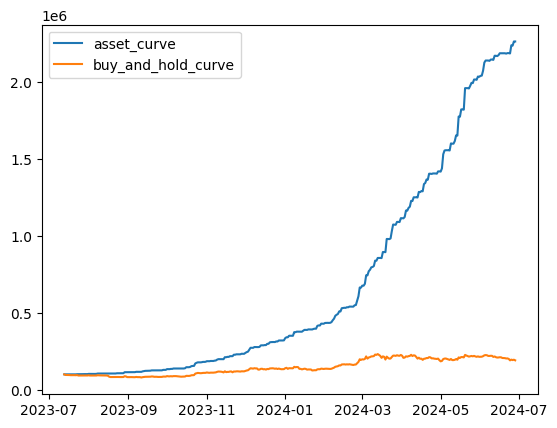

,entry_date,entry_price,exit_date,exit_price,return,holding_days
0,2023-07-18,29856.562500,2023-07-19,29913.923828,0.001921,1
1,2023-07-20,29792.015625,2023-07-21,29908.744141,0.003918,1
2,2023-07-22,29771.802734,2023-07-23,30084.539062,0.010504,1
3,2023-07-24,29176.916016,2023-07-26,29354.972656,0.006103,2
4,2023-07-27,29210.689453,2023-07-29,29356.917969,0.005006,2
...,...,...,...,...,...,...
89,2024-06-11,67332.031250,2024-06-12,68241.187500,0.013503,1
90,2024-06-14,66011.093750,2024-06-16,66639.046875,0.009513,2
91,2024-06-21,64096.199219,2024-06-22,64252.578125,0.002440,1
92,2024-06-24,60277.414062,2024-06-25,61804.640625,0.025337,1


In [236]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
initial_cash=100000
end_date = datetime.today() - timedelta(days=365)
start_date = datetime.today() - timedelta(days=365*2)
train_data,pred_data,feature_cols = get_data(start_date,end_date)
strategy = RandomForestStrategy(data=pred_data, feature_cols=feature_cols)
strategy.load_model('model.pkl')
result = backtest_strategy(strategy=strategy, data=pred_data,initial_cash=initial_cash,start_date=start_date,end_date=end_date)
print(f"總報酬率: {result['total_return']:.2%}")
print(f"年化報酬率: {result['cagr']:.2%}")
print(f"夏普比率: {result['sharpe_ratio']:.2f}")
print(f"最大回撤: {result['max_drawdown']:.2%}")
print(f"勝率: {result['win_rate']:.2%}")
print(f"平均盈虧比: {result['profit_loss_ratio_avg']:.2f}")
print(f"總盈虧比: {result['profit_loss_ratio_total']:.2f}")
print(f"期望值: {result['expectancy']:.4f}")
print(f"平均持倉日: {result['avg_holding_days']:.2f}")
print(f"總交易次數: {result['num_trades']}")
plt.plot(result['asset_curve'],label='asset_curve')
plt.plot(result['buy_and_hold_curve'],label='buy_and_hold_curve')
plt.legend()
plt.show()
result['trades']

# 觀察模型在2024到2025的表現

[*********************100%***********************]  1 of 1 completed


模型已從 model.pkl 載入成功
交易信號產生完成
總報酬率: 135.36%
年化報酬率: 143.68%
夏普比率: 2.00
最大回撤: -20.68%
勝率: 63.77%
平均盈虧比: 1.67
總盈虧比: 2.94
期望值: 0.0156
平均持倉日: 3.07
總交易次數: 69


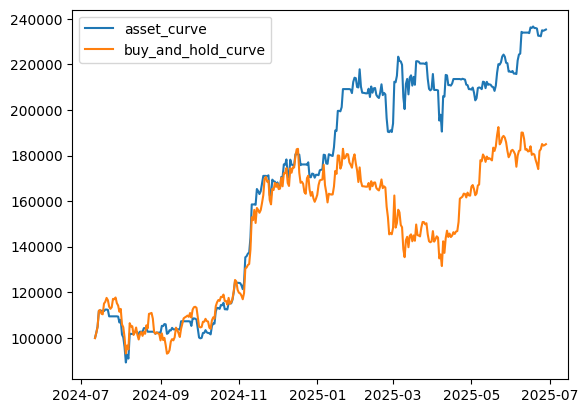

,entry_date,entry_price,exit_date,exit_price,return,holding_days
0,2024-07-12,57899.464844,2024-07-15,64870.152344,0.120393,3
1,2024-07-19,66710.156250,2024-07-20,67163.648438,0.006798,1
2,2024-07-22,67585.250000,2024-07-23,65927.671875,-0.024526,1
3,2024-07-30,66201.015625,2024-08-08,61710.136719,-0.067837,9
4,2024-08-09,60880.113281,2024-08-10,60945.812500,0.001079,1
...,...,...,...,...,...,...
64,2025-06-15,105552.023438,2025-06-16,106796.757812,0.011793,1
65,2025-06-17,104601.117188,2025-06-19,104684.289062,0.000795,2
66,2025-06-21,102257.406250,2025-06-22,100987.140625,-0.012422,1
67,2025-06-24,106045.632812,2025-06-25,107361.257812,0.012406,1


In [237]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
initial_cash=100000
end_date = datetime.today()
start_date = datetime.today() - timedelta(days=365)
train_data,pred_data,feature_cols = get_data(start_date,end_date)
strategy = RandomForestStrategy(data=pred_data, feature_cols=feature_cols)
strategy.load_model('model.pkl')
result = backtest_strategy(strategy=strategy, data=pred_data,initial_cash=initial_cash,start_date=start_date,end_date=end_date)
print(f"總報酬率: {result['total_return']:.2%}")
print(f"年化報酬率: {result['cagr']:.2%}")
print(f"夏普比率: {result['sharpe_ratio']:.2f}")
print(f"最大回撤: {result['max_drawdown']:.2%}")
print(f"勝率: {result['win_rate']:.2%}")
print(f"平均盈虧比: {result['profit_loss_ratio_avg']:.2f}")
print(f"總盈虧比: {result['profit_loss_ratio_total']:.2f}")
print(f"期望值: {result['expectancy']:.4f}")
print(f"平均持倉日: {result['avg_holding_days']:.2f}")
print(f"總交易次數: {result['num_trades']}")
plt.plot(result['asset_curve'],label='asset_curve')
plt.plot(result['buy_and_hold_curve'],label='buy_and_hold_curve')
plt.legend()
plt.show()
result['trades']